# Demo: Roman CGI PSF models with WebbPSF

This tutorial will walk you through the basics of using the WebbPSF package to generate PSF models for the Roman CGI. If this is your first time using WebbPSF, it could be worthwhile to first go through the original WebbPSF tutorial notebook, hosted at https://github.com/spacetelescope/webbpsf/blob/master/notebooks/WebbPSF_tutorial.ipynb.

Current functionality is limited to the Shaped Pupil Coronagraph (SPC) observing modes, and these modes are only simulated with static, unaberrated wavefronts, without relay optics and without DM control. The design respresented here is an approximation to a baseline concept, and will be subject to change based on ongoing trades studies and technology development.

First, we set up the notebook to display plots inline, and to plot images with the origin in the lower left.

In [1]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'

Populating the interactive namespace from numpy and matplotlib


## Load packages

In [2]:
import os
#os.environ['WEBBPSF_PATH'] = 
import webbpsf
from webbpsf import roman
import ipywidgets
from astropy.io import fits

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-027 IS BEHIND THE CURRENT ONLINE VERSION PRDOPSSOC-031
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


WebbPSF produces various log messages while it works, using Python's built-in logging mechanism. In order to see them, we need to set up a log handler that will display them on the screen. This is done using the ``setup_logging`` function. 

In [3]:
webbpsf.setup_logging()

WebbPSF log messages of level INFO and above will be shown.
WebbPSF log outputs will be directed to the screen.


We can also choose to save log outputs to a file, if that's desired.

## Shaped pupil coronagraph PSF

The list of supported observing modes is a private attribute of the CGI instrument subclass. If we instantiate a coronagraph without specifying a mode keyword, the init function will print the table and note the default settings.

In [4]:
default_cgi = roman.CGI()

[webbpsf] Printing the table of Roman CGI observing modes supported by WebbPSF.
[webbpsf] Each is defined by a combo of camera, filter, apodizer, focal plane mask (FPM), and Lyot stop settings:
[webbpsf] {'CHARSPC_F660': ('IFS', 'F660', 'CHARSPC', 'CHARSPC_F660_BOWTIE', 'LS30D88'),
 'CHARSPC_F770': ('IFS', 'F770', 'CHARSPC', 'CHARSPC_F770_BOWTIE', 'LS30D88'),
 'CHARSPC_F890': ('IFS', 'F890', 'CHARSPC', 'CHARSPC_F890_BOWTIE', 'LS30D88'),
 'DISKSPC_F721': ('IMAGER',
                  'F721',
                  'DISKSPC',
                  'DISKSPC_F721_ANNULUS',
                  'LS30D88')}
[webbpsf] Since the mode was not specified at instantiation, defaulting to CHARSPC_F660
[webbpsf] Set the following optical configuration:
[webbpsf] camera = IFS, filter = F660, apodizer = CHARSPC, fpm = CHARSPC_F660_BOWTIE, lyotstop = LS30D88


There are two shaped pupil coronagraphs implemented so far: 'CHARSPC' and 'DISKSPC' -- these are the atmospheric characterization and debris disk imaging modes of CGI, respectively. The filters choices for 'CHARSPC' are 'F660','F770', and 'F890' (18% bandwidth IFS filters centered at 660 nm, 770 nm, and 890 nm). The 'DISKSPC' operates with one filter, 'F721', centered at 721 nm with a 5% bandwidth imaging filter. All of these coronagraphs us the same Lyot stop.

Now let's make a new object specifying the characterization mode centered at wavelength 770 nm.

In [5]:
char_spc = roman.CGI(mode='CHARSPC_F770')

[webbpsf] Set the following optical configuration:
[webbpsf] camera = IFS, filter = F770, apodizer = CHARSPC, fpm = CHARSPC_F770_BOWTIE, lyotstop = LS30D88


We can use the ``display()`` method of the new optical system to show the masks that define the coronagraph, starting from the telescope pupil. 

[  poppy] No source spectrum supplied, therefore defaulting to 5700 K blackbody
[  poppy] Computing wavelength weights using synthetic photometry for F770...
[webbpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: Roman+CGI
[  poppy] Roman Entrance Pupil: Loaded amplitude transmission from /Users/rgeda/project/data/webbpsf-data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits
[  poppy] Added pupil plane: Roman Entrance Pupil
[  poppy] Added coordinate inversion plane: OTE exit pupil
[  poppy] CHARSPC: Loaded amplitude transmission from /Users/rgeda/project/data/webbpsf-data/CGI/optics/CHARSPC_SP_256pix.fits.gz
[  poppy] Added pupil plane: CHARSPC
[  poppy] CHARSPC_F770_BOWTIE: Loaded amplitude transmission from /Users/rgeda/project/data/webbpsf-data/CGI/optics/CHARSPC_FPM_25WA90_2x65deg_-_FP1res4_evensamp_D072_F770.fits.gz
[  poppy] Added image plane: CHARSPC_F770_BOWTIE
[  poppy] LS30D88: Loaded amplitude transmission from /Users/rgeda/project/data/webbpsf-data/CGI/optics/

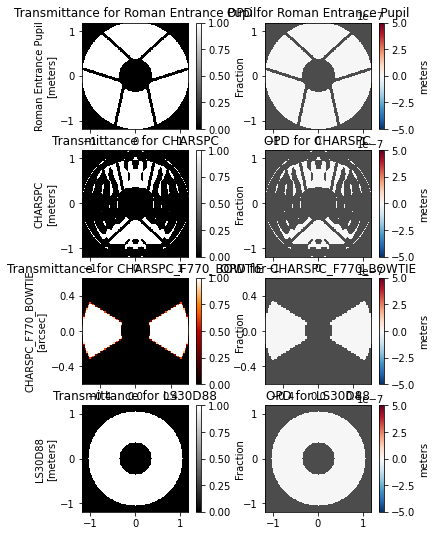

In [6]:
plt.figure(figsize=(6,9))
char_spc.display()

To simulate the PSF, we then call its ``calc_psf`` function.  Note the log output describes various details of the calculation as it proceeds. The returned result is a fits HDUList object containing both the image data and its associated metadata in the header. 

[  poppy] No source spectrum supplied, therefore defaulting to 5700 K blackbody
[  poppy] PSF calc using fov_arcsec = 1.600000, oversample = 4, number of wavelengths = 1
[webbpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: Roman+CGI
[  poppy] Roman Entrance Pupil: Loaded amplitude transmission from /Users/rgeda/project/data/webbpsf-data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits
[  poppy] Added pupil plane: Roman Entrance Pupil
[  poppy] Added coordinate inversion plane: OTE exit pupil
[  poppy] CHARSPC: Loaded amplitude transmission from /Users/rgeda/project/data/webbpsf-data/CGI/optics/CHARSPC_SP_256pix.fits.gz
[  poppy] Added pupil plane: CHARSPC
[  poppy] CHARSPC_F770_BOWTIE: Loaded amplitude transmission from /Users/rgeda/project/data/webbpsf-data/CGI/optics/CHARSPC_FPM_25WA90_2x65deg_-_FP1res4_evensamp_D072_F770.fits.gz
[  poppy] Added image plane: CHARSPC_F770_BOWTIE
[  poppy] LS30D88: Loaded amplitude transmission from /Users/rgeda/project/data/webbpsf-data

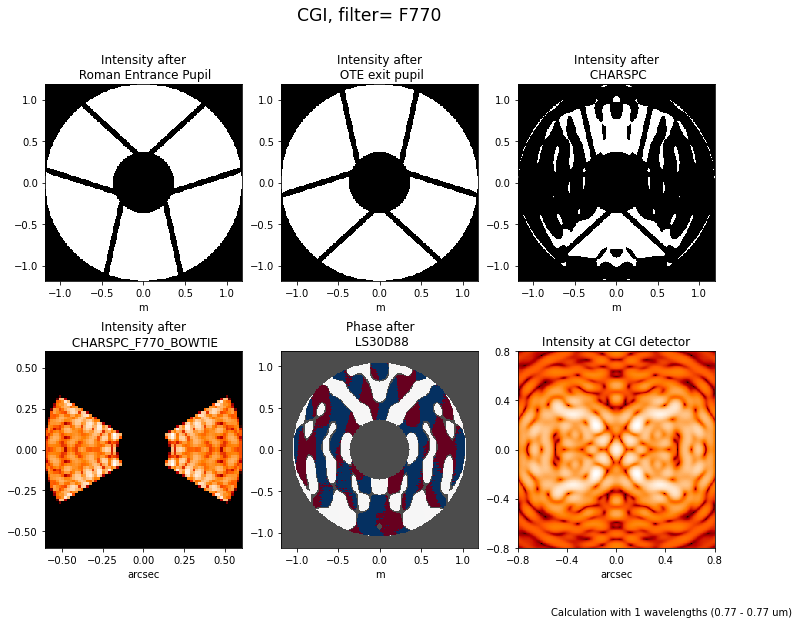

In [7]:
plt.figure(figsize=(12,9))
mono_char_spc_psf = char_spc.calc_psf(nlambda=1, fov_arcsec=1.6, display=True)

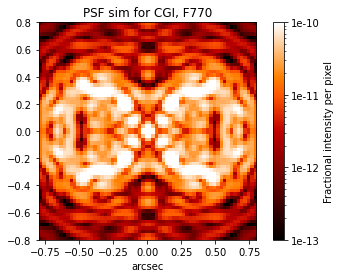

In [8]:
webbpsf.display_psf(mono_char_spc_psf,ext=1,vmin=1e-13, vmax=1e-10)

Note, in Poppy/WebbPSF the PSF intensity values are normalized to the sum of the intensity in the telescope pupil. Therefore, the values in the intensity colorbar are NOT contrast units. In the next example, we will show how to display the PSF result in contrast units.

## Integral field spectrograph PSF with the characterization SPC

In [9]:
webbpsf.setup_logging('ERROR') # Reduce the verbosity

WebbPSF log messages of level ERROR and above will be shown.
WebbPSF log outputs will be directed to the screen.


To approximate the PSF produced by the integral field spectrograph, we can form a cube of monochromatic PSFs computed at wavelengths spanning the bandpass:

In [10]:
ifs_spc = roman.CGI()
ifs_spc.mode = 'CHARSPC_F890'

filter_fname = ifs_spc._filters[ifs_spc.filter].filename
filter_hdulist = fits.open(filter_fname)
wave_beg = (float(filter_hdulist[1].header.get('LAMBDA0')) - float(filter_hdulist[1].header.get('DELTALAM'))/2)
wave_end = (float(filter_hdulist[1].header.get('LAMBDA0')) + float(filter_hdulist[1].header.get('DELTALAM'))/2)
deltalam_ifs = float(filter_hdulist[1].header.get('LAMBDA0'))/70. # Assume spectral resolution R = 70
Nchan = (int(np.floor((wave_end - wave_beg)/deltalam_ifs))//2)*2 + 1 # Number of channels, forced to an odd integer
wavelens = np.linspace(wave_beg, wave_end, Nchan) * 1e-10 # all wavelengths to model, in meters

lamoD_asec = float(filter_hdulist[1].header.get('LAMBDA0'))*1e-10/(2*ifs_spc.PUPIL_RADIUS) * 180/np.pi * 3600
print("System diffraction resolution element scale (lambda_0/D) in arcsec: %.3f" % lamoD_asec)
print("IFS spectral parameters: %d channels of characteristic spectral width %.2f nm," % (Nchan,deltalam_ifs/10.))
print("ranging from %d nm to %d nm, centered on %d nm" % (wavelens[0]*1e9, wavelens[-1]*1e9, wavelens[Nchan//2]*1e9))
filter_hdulist.close()

System diffraction resolution element scale (lambda_0/D) in arcsec: 0.076
IFS spectral parameters: 13 channels of characteristic spectral width 12.71 nm,
ranging from 809 nm to 970 nm, centered on 890 nm


In [11]:
ifs_spc.options['source_offset_r'] = 0 # arcsec
ifs_spc.options['source_offset_theta'] = 0 # deg w.r.t. North

ifs_psf_onax = ifs_spc.calc_datacube(wavelens, fov_arcsec=1.64, oversample=4, display=False)
print("The resulting data cube has dimensions {} wavelengths x {} pixels x {} pixels".format\
      (ifs_psf_onax[1].data.shape[0], ifs_psf_onax[1].data.shape[1], ifs_psf_onax[1].data.shape[2]))

The resulting data cube has dimensions 13 wavelengths x 66 pixels x 66 pixels


### Convert the PSF cube intensity values to units of contrast, using the off-axis PSF 

We can use the source offset option to propagate a plane wave through the transmitted region of the focal plane mask. This provides a close approximation for the peak of the target star PSF if we had not occulted it, which in turn determines the conversion factor to contrast units.

In [12]:
ifs_spc.options['source_offset_r'] = 6*lamoD_asec # 6 lam/D in arcsec
ifs_spc.options['source_offset_theta'] = -90. # deg w.r.t. North

ifs_psf_offax = ifs_spc.calc_datacube(wavelens, fov_arcsec=1.64, oversample=4, display=False)
offax_peak_vec = np.max(np.max(ifs_psf_offax[1].data, axis=-1), axis=-1)
offax_peak_cube = np.tile(offax_peak_vec[:,np.newaxis,np.newaxis],
                          (1, ifs_psf_onax[1].data.shape[-2], ifs_psf_onax[1].data.shape[-1]))

ifs_psf_onax_contrast = ifs_psf_onax[1].data / offax_peak_cube

## Plot the polychromatic PSF cube of the IFS in contrast units. 

In [13]:
def plt_ifs_psf_onax(wchan):
    plt.imshow(ifs_psf_onax_contrast[wchan-1], norm=matplotlib.colors.LogNorm(),
               vmin=3e-10, vmax=3e-8, cmap='gist_heat')
    plt.colorbar()
ipywidgets.interact(plt_ifs_psf_onax, wchan=(1,Nchan));

interactive(children=(IntSlider(value=7, description='wchan', max=13, min=1), Output()), _dom_classes=('widget…

### Plot the off-axis PSF used for the contrast calibration

In [14]:
def plt_ifs_psf_offax(wchan):
    plt.imshow(ifs_psf_offax[1].data[wchan-1], cmap='gist_heat');
    plt.colorbar()
ipywidgets.interact(plt_ifs_psf_offax, wchan=(1,len(wavelens)));

interactive(children=(IntSlider(value=7, description='wchan', max=13, min=1), Output()), _dom_classes=('widget…

# Debris disk mode SPC

In [15]:
diskcg = roman.CGI(mode='DISKSPC_F721')
diskcg.options['source_offset_r'] = 0 # arcsec
diskcg.options['source_offset_theta'] = 0 # deg w.r.t. North

In [16]:
diskpsf_onax = diskcg.calc_psf(fov_arcsec=2.2, display=False)

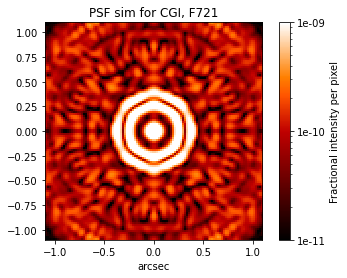

In [17]:
webbpsf.display_psf(diskpsf_onax,ext=1,vmin=1e-11, vmax=1e-9)

## Off-axis PSF

In [18]:
diskcg.options['source_offset_r'] = 0.6 # arcsec
diskcg.options['source_offset_theta'] = -45. # deg w.r.t. North

/Users/rgeda/project/repo/poppy/poppy/poppy_core.py:518: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(nr, nc, int(row))
/Users/rgeda/project/repo/poppy/poppy/poppy_core.py:518: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(nr, nc, int(row))
/Users/rgeda/project/repo/poppy/poppy/poppy_core.py:518: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently 

/Users/rgeda/project/repo/poppy/poppy/poppy_core.py:518: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(nr, nc, int(row))
/Users/rgeda/project/repo/poppy/poppy/poppy_core.py:497: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(nr, nc, int(row))
/Users/rgeda/project/repo/poppy/poppy/poppy_core.py:518: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently 

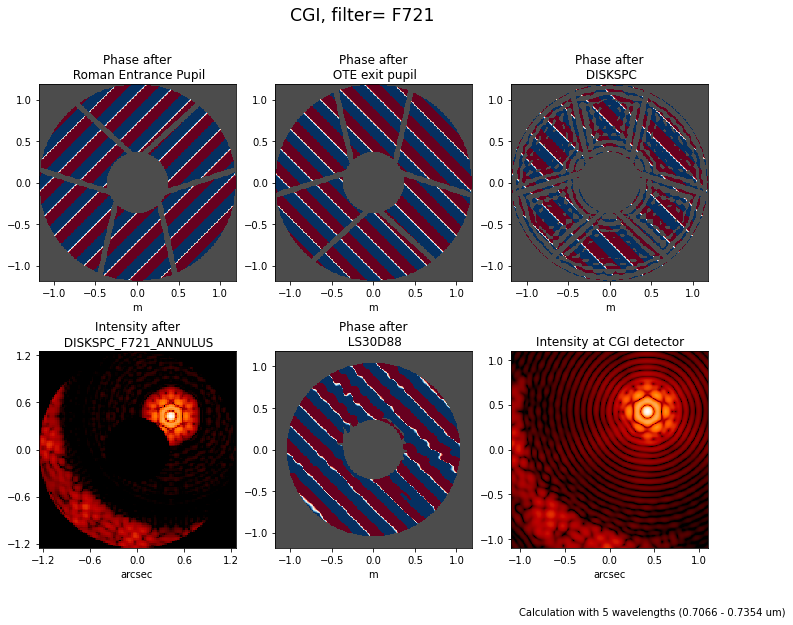

In [19]:
plt.figure(figsize=(12,9))
diskpsf_offax = diskcg.calc_psf(fov_arcsec=2.2, display=True)
diskpsf_offax_peak = diskpsf_offax[1].data.max()

In [20]:
# Form a simple bright companion scene by summing the on-axis and off-axis PSF, the latter scaled by 1E-7.
comb_img = (diskpsf_onax[1].data + diskpsf_offax[1].data*1e-7)/diskpsf_offax_peak # Contrast units
comb_hdu = fits.PrimaryHDU(comb_img, header=diskpsf_onax[1].header)
comb_hdulist = fits.HDUList([comb_hdu])

### Plot composite disk SPC PSF (on-axis + off-axis@1E-7 contrast) in units of contrast 

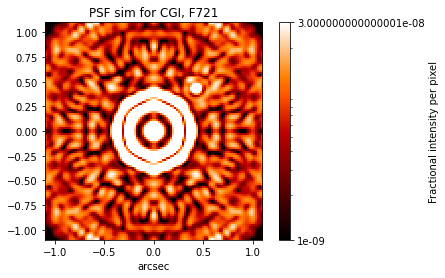

In [21]:
webbpsf.display_psf(comb_hdulist,vmin=1e-9, vmax=3e-8)